In [9]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('GOOGL.csv')
df = df[['Date', 'Close']]
df = df.rename({'Close': 'Price'}, axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Price
Date,
2021-02-08,2084.520020
2021-02-09,2075.389893
2021-02-10,2086.479980
2021-02-11,2088.750000
2021-02-12,2095.030029
...,...
2022-02-01,2752.879883
2022-02-02,2960.000000
2022-02-03,2861.800049


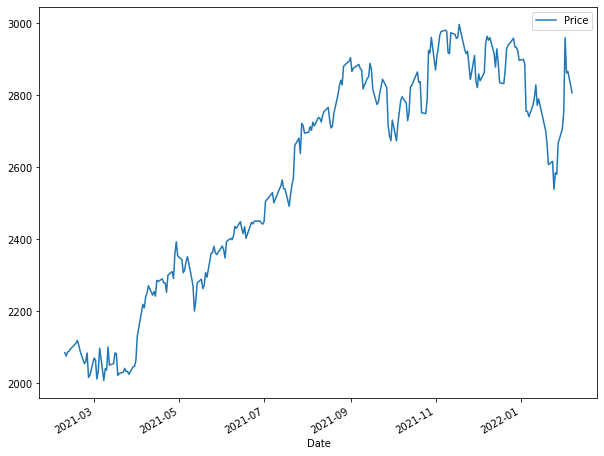

In [11]:
df.plot(figsize=(10,8))

In [12]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int, 
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for layer in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='Theta_Layer')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

    return backcast, forecast

In [13]:
EPOCHS = 2000
N_NEURONS = 512
N_LAYERS = 8
N_STACKS = 30

WINDOW_SIZE = 7
HORIZON = 1

INPUT_SIZE = WINDOW_SIZE
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [14]:
nbeats_data = df.copy()

for i in range(WINDOW_SIZE):
  nbeats_data[f'Price{i+1}'] = nbeats_data['Price'].shift(periods=i+1)

nbeats_data = nbeats_data.dropna()

nbeats_data

,Price,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,,
2021-02-18,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980,2075.389893,2084.520020
2021-02-19,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980,2075.389893
2021-02-22,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980
2021-02-23,2060.120117,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000
2021-02-24,2083.810059,2060.120117,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029
...,...,...,...,...,...,...,...,...
2022-02-01,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951,2616.080078,2607.030029
2022-02-02,2960.000000,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951,2616.080078
2022-02-03,2861.800049,2960.000000,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951


In [15]:
X = nbeats_data.drop("Price", axis=1)
y = nbeats_data['Price']

In [16]:
X

,Price1,Price2,Price3,Price4,Price5,Price6,Price7
Date,,,,,,,
2021-02-18,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980,2075.389893,2084.520020
2021-02-19,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980,2075.389893
2021-02-22,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000,2086.479980
2021-02-23,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029,2088.750000
2021-02-24,2060.120117,2054.260010,2088.810059,2105.810059,2118.620117,2110.699951,2095.030029
...,...,...,...,...,...,...,...
2022-02-01,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951,2616.080078,2607.030029
2022-02-02,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951,2616.080078
2022-02-03,2960.000000,2752.879883,2706.070068,2667.020020,2580.100098,2584.659912,2538.699951


In [17]:
y

Date
2021-02-18    2105.810059
2021-02-19    2088.810059
2021-02-22    2054.260010
2021-02-23    2060.120117
2021-02-24    2083.810059
                 ...     
2022-02-01    2752.879883
2022-02-02    2960.000000
2022-02-03    2861.800049
2022-02-04    2865.860107
2022-02-07    2806.760010
Name: Price, Length: 246, dtype: float64

In [18]:
split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(196, 196, 50, 50)

In [19]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [20]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [21]:
nbeats_predictor = NBeatsBlock(input_size=INPUT_SIZE,
                               theta_size=THETA_SIZE,
                               horizon=HORIZON,
                               n_neurons=N_NEURONS,
                               n_layers=N_LAYERS,
                               name='nbeats_block_00')

stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name='stack_input')

backcast, forecast = nbeats_predictor(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name='subtract_00')


for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                         theta_size=THETA_SIZE,
                                         horizon=HORIZON,
                                         n_neurons=N_NEURONS,
                                         n_layers=N_LAYERS,
                                         name=f"nbeats_block_{i}")(residuals)

  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f'add_{i}')


model = tf.keras.Model(inputs=stack_input, outputs=forecast, name='nbeats_model')

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae', 'mse'])


model.fit(train_dataset, 
          epochs=EPOCHS, 
          validation_data=test_dataset,
          callbacks=[create_model_checkpoint(model_name=model.name)])


Epoch 1/2000
7/7 [==============================] - ETA: 0s - loss: 3435.7612 - mae: 3435.7612 - mse: 28472814.0000

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 61s 7s/step - loss: 3435.7612 - mae: 3435.7612 - mse: 28472814.0000 - val_loss: 1766.9364 - val_mae: 1766.9364 - val_mse: 3138103.0000
Epoch 2/2000
7/7 [==============================] - ETA: 0s - loss: 860.6357 - mae: 860.6357 - mse: 851233.0625

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 42s 7s/step - loss: 860.6357 - mae: 860.6357 - mse: 851233.0625 - val_loss: 67.9709 - val_mae: 67.9709 - val_mse: 8271.7002
Epoch 3/2000
7/7 [==============================] - 1s 123ms/step - loss: 450.6671 - mae: 450.6671 - mse: 336437.0312 - val_loss: 371.6578 - val_mae: 371.6578 - val_mse: 148160.4375
Epoch 4/2000
7/7 [==============================] - 1s 122ms/step - loss: 203.4201 - mae: 203.4201 - mse: 51158.0859 - val_loss: 143.7317 - val_mae: 143.7317 - val_mse: 28585.9902
Epoch 5/2000
7/7 [==============================] - 1s 124ms/step - loss: 132.3744 - mae: 132.3744 - mse: 22507.9941 - val_loss: 166.1058 - val_mae: 166.1058 - val_mse: 36020.2070
Epoch 6/2000
7/7 [==============================] - 1s 123ms/step - loss: 92.9404 - mae: 92.9404 - mse: 11604.3584 - val_loss: 74.5473 - val_mae: 74.5473 - val_mse: 8749.1787
Epoch 7/2000
7/7 [==============================] - ETA: 0s - loss: 44.2020 - mae: 44.2020 - mse: 3129.8503

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 42s 7s/step - loss: 44.2020 - mae: 44.2020 - mse: 3129.8503 - val_loss: 66.0429 - val_mae: 66.0429 - val_mse: 7771.6035
Epoch 8/2000
7/7 [==============================] - 1s 122ms/step - loss: 65.7927 - mae: 65.7927 - mse: 6783.1880 - val_loss: 66.1554 - val_mae: 66.1554 - val_mse: 7832.4014
Epoch 9/2000
7/7 [==============================] - ETA: 0s - loss: 41.4619 - mae: 41.4619 - mse: 2826.7290

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 42s 7s/step - loss: 41.4619 - mae: 41.4619 - mse: 2826.7290 - val_loss: 64.7999 - val_mae: 64.7999 - val_mse: 7123.7783
Epoch 10/2000
7/7 [==============================] - 1s 122ms/step - loss: 53.8135 - mae: 53.8135 - mse: 4444.2925 - val_loss: 88.9137 - val_mae: 88.9137 - val_mse: 12895.5635
Epoch 11/2000
7/7 [==============================] - 1s 125ms/step - loss: 80.5966 - mae: 80.5966 - mse: 9647.8447 - val_loss: 82.4305 - val_mae: 82.4305 - val_mse: 11567.1289
Epoch 12/2000
7/7 [==============================] - 1s 120ms/step - loss: 52.7374 - mae: 52.7374 - mse: 4165.5430 - val_loss: 65.8314 - val_mae: 65.8314 - val_mse: 7683.1626
Epoch 13/2000
7/7 [==============================] - ETA: 0s - loss: 44.4979 - mae: 44.4979 - mse: 3202.2559

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 42s 7s/step - loss: 44.4979 - mae: 44.4979 - mse: 3202.2559 - val_loss: 61.6487 - val_mae: 61.6487 - val_mse: 6759.4160
Epoch 14/2000
7/7 [==============================] - ETA: 0s - loss: 39.2356 - mae: 39.2356 - mse: 2453.0320

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 41s 7s/step - loss: 39.2356 - mae: 39.2356 - mse: 2453.0320 - val_loss: 58.6859 - val_mae: 58.6859 - val_mse: 5863.6719
Epoch 15/2000
7/7 [==============================] - 1s 123ms/step - loss: 57.3019 - mae: 57.3019 - mse: 4867.3726 - val_loss: 67.3837 - val_mae: 67.3837 - val_mse: 7396.2896
Epoch 16/2000
7/7 [==============================] - 1s 122ms/step - loss: 38.9780 - mae: 38.9780 - mse: 2742.7573 - val_loss: 86.0574 - val_mae: 86.0574 - val_mse: 11649.1621
Epoch 17/2000
7/7 [==============================] - 1s 123ms/step - loss: 65.7406 - mae: 65.7406 - mse: 6150.1733 - val_loss: 78.4360 - val_mae: 78.4360 - val_mse: 9069.5078
Epoch 18/2000
7/7 [==============================] - 1s 126ms/step - loss: 42.6808 - mae: 42.6808 - mse: 2784.6233 - val_loss: 60.6671 - val_mae: 60.6671 - val_mse: 6427.7681
Epoch 19/2000
7/7 [==============================] - 1s 122ms/step - loss: 52.7554 - mae: 52.7554 - mse: 4313.6201 - val_loss: 103.5000 - va

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 42s 7s/step - loss: 44.6042 - mae: 44.6042 - mse: 3023.0146 - val_loss: 54.9160 - val_mae: 54.9160 - val_mse: 5350.0498
Epoch 85/2000
7/7 [==============================] - 1s 123ms/step - loss: 52.7101 - mae: 52.7101 - mse: 4048.6357 - val_loss: 68.6842 - val_mae: 68.6842 - val_mse: 7254.5361
Epoch 86/2000
7/7 [==============================] - 1s 122ms/step - loss: 45.6910 - mae: 45.6910 - mse: 3046.7915 - val_loss: 69.5640 - val_mae: 69.5640 - val_mse: 7403.2686
Epoch 87/2000
7/7 [==============================] - ETA: 0s - loss: 41.4346 - mae: 41.4346 - mse: 2609.2834

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 41s 7s/step - loss: 41.4346 - mae: 41.4346 - mse: 2609.2834 - val_loss: 54.6640 - val_mae: 54.6640 - val_mse: 5199.5000


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 88/2000
7/7 [==============================] - 1s 124ms/step - loss: 49.4811 - mae: 49.4811 - mse: 3601.7498 - val_loss: 65.9017 - val_mae: 65.9017 - val_mse: 6766.1587
Epoch 89/2000
7/7 [==============================] - 1s 122ms/step - loss: 43.5263 - mae: 43.5263 - mse: 2784.6418 - val_loss: 66.4390 - val_mae: 66.4390 - val_mse: 6815.5498
Epoch 90/2000
7/7 [==============================] - ETA: 0s - loss: 39.6623 - mae: 39.6623 - mse: 2447.8757

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 42s 7s/step - loss: 39.6623 - mae: 39.6623 - mse: 2447.8757 - val_loss: 51.8325 - val_mae: 51.8325 - val_mse: 4890.4634
Epoch 91/2000
7/7 [==============================] - 1s 124ms/step - loss: 50.7780 - mae: 50.7780 - mse: 3726.6123 - val_loss: 63.8772 - val_mae: 63.8772 - val_mse: 6454.8174
Epoch 92/2000
7/7 [==============================] - 1s 123ms/step - loss: 47.4620 - mae: 47.4620 - mse: 3262.6096 - val_loss: 52.7648 - val_mae: 52.7648 - val_mse: 5112.3564
Epoch 93/2000
7/7 [==============================] - 1s 122ms/step - loss: 50.7565 - mae: 50.7565 - mse: 3759.6531 - val_loss: 59.8896 - val_mae: 59.8896 - val_mse: 5978.8052
Epoch 94/2000
7/7 [==============================] - 1s 123ms/step - loss: 51.5072 - mae: 51.5072 - mse: 3869.8042 - val_loss: 72.0265 - val_mae: 72.0265 - val_mse: 7918.2651
Epoch 95/2000
7/7 [==============================] - 1s 123ms/step - loss: 40.3633 - mae: 40.3633 - mse: 2487.4368 - val_loss: 54.3422 - val_

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 42s 7s/step - loss: 36.8255 - mae: 36.8255 - mse: 2143.7649 - val_loss: 50.5041 - val_mae: 50.5041 - val_mse: 4378.5132
Epoch 105/2000
7/7 [==============================] - 1s 124ms/step - loss: 44.9361 - mae: 44.9361 - mse: 3001.4021 - val_loss: 65.0193 - val_mae: 65.0193 - val_mse: 6579.7148
Epoch 106/2000
7/7 [==============================] - 1s 124ms/step - loss: 40.4499 - mae: 40.4499 - mse: 2431.2930 - val_loss: 64.5848 - val_mae: 64.5848 - val_mse: 6210.6167
Epoch 107/2000
7/7 [==============================] - 1s 125ms/step - loss: 35.6836 - mae: 35.6836 - mse: 2008.2996 - val_loss: 52.6952 - val_mae: 52.6952 - val_mse: 5085.4702
Epoch 108/2000
7/7 [==============================] - 1s 125ms/step - loss: 51.4570 - mae: 51.4570 - mse: 3813.4941 - val_loss: 55.1456 - val_mae: 55.1456 - val_mse: 5222.6475
Epoch 109/2000
7/7 [==============================] - 1s 124ms/step - loss: 52.2042 - mae: 52.2042 - mse: 3883.0535 - val_loss: 82.6493 -

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 42s 7s/step - loss: 41.2396 - mae: 41.2396 - mse: 2608.8521 - val_loss: 50.4208 - val_mae: 50.4208 - val_mse: 4610.9346


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 116/2000
7/7 [==============================] - 1s 125ms/step - loss: 48.0364 - mae: 48.0364 - mse: 3404.1853 - val_loss: 66.0180 - val_mae: 66.0180 - val_mse: 6651.8735
Epoch 117/2000
7/7 [==============================] - 1s 124ms/step - loss: 38.4386 - mae: 38.4386 - mse: 2270.3325 - val_loss: 65.9563 - val_mae: 65.9563 - val_mse: 6436.7539
Epoch 118/2000
7/7 [==============================] - 1s 125ms/step - loss: 38.1772 - mae: 38.1772 - mse: 2407.2415 - val_loss: 51.9764 - val_mae: 51.9764 - val_mse: 4696.6187
Epoch 119/2000
7/7 [==============================] - 1s 124ms/step - loss: 46.0509 - mae: 46.0509 - mse: 3155.4897 - val_loss: 61.6763 - val_mae: 61.6763 - val_mse: 6076.6704
Epoch 120/2000
7/7 [==============================] - 1s 124ms/step - loss: 42.1245 - mae: 42.1245 - mse: 2634.0999 - val_loss: 64.9910 - val_mae: 64.9910 - val_mse: 6648.2876
Epoch 121/2000
7/7 [==============================] - 1s 125ms/step - loss: 37.4968 - mae: 37.4968 - mse: 2162.9065 - va

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 41s 7s/step - loss: 37.4636 - mae: 37.4636 - mse: 2199.8848 - val_loss: 49.1704 - val_mae: 49.1704 - val_mse: 4328.8398
Epoch 126/2000
7/7 [==============================] - 1s 123ms/step - loss: 41.6817 - mae: 41.6817 - mse: 2639.0134 - val_loss: 53.1240 - val_mae: 53.1240 - val_mse: 4767.0601
Epoch 127/2000
7/7 [==============================] - 1s 122ms/step - loss: 41.6651 - mae: 41.6651 - mse: 2623.0071 - val_loss: 65.7670 - val_mae: 65.7670 - val_mse: 6471.8638
Epoch 128/2000
7/7 [==============================] - 1s 124ms/step - loss: 39.1041 - mae: 39.1041 - mse: 2334.4883 - val_loss: 65.8606 - val_mae: 65.8606 - val_mse: 6462.7319
Epoch 129/2000
7/7 [==============================] - 1s 125ms/step - loss: 36.1440 - mae: 36.1440 - mse: 2047.5286 - val_loss: 63.0500 - val_mae: 63.0500 - val_mse: 6036.7651
Epoch 130/2000
7/7 [==============================] - 1s 123ms/step - loss: 37.2351 - mae: 37.2351 - mse: 2208.2810 - val_loss: 52.7331 -

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 41s 7s/step - loss: 32.8355 - mae: 32.8355 - mse: 1838.0361 - val_loss: 47.7566 - val_mae: 47.7566 - val_mse: 4105.4463
Epoch 140/2000
7/7 [==============================] - 1s 122ms/step - loss: 41.6401 - mae: 41.6401 - mse: 2616.0032 - val_loss: 48.1633 - val_mae: 48.1633 - val_mse: 4075.5405
Epoch 141/2000
7/7 [==============================] - 1s 125ms/step - loss: 43.1548 - mae: 43.1548 - mse: 2788.0710 - val_loss: 69.6638 - val_mae: 69.6638 - val_mse: 6992.6514
Epoch 142/2000
7/7 [==============================] - 1s 122ms/step - loss: 36.4829 - mae: 36.4829 - mse: 2030.8479 - val_loss: 71.6442 - val_mae: 71.6442 - val_mse: 7366.7402
Epoch 143/2000
7/7 [==============================] - 1s 122ms/step - loss: 36.0169 - mae: 36.0169 - mse: 1955.8358 - val_loss: 67.9434 - val_mae: 67.9434 - val_mse: 6803.1089
Epoch 144/2000
7/7 [==============================] - 1s 122ms/step - loss: 35.4449 - mae: 35.4449 - mse: 1926.1522 - val_loss: 71.3627 -

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 41s 7s/step - loss: 32.0852 - mae: 32.0852 - mse: 1677.7001 - val_loss: 47.1188 - val_mae: 47.1188 - val_mse: 4077.0342


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 149/2000
7/7 [==============================] - 1s 125ms/step - loss: 42.4974 - mae: 42.4974 - mse: 2727.6169 - val_loss: 51.4543 - val_mae: 51.4543 - val_mse: 4563.2080
Epoch 150/2000
7/7 [==============================] - 1s 122ms/step - loss: 49.1455 - mae: 49.1455 - mse: 3479.7148 - val_loss: 84.4889 - val_mae: 84.4889 - val_mse: 9776.1436
Epoch 151/2000
7/7 [==============================] - 1s 122ms/step - loss: 57.3276 - mae: 57.3276 - mse: 4529.1206 - val_loss: 56.6323 - val_mae: 56.6323 - val_mse: 5636.2827
Epoch 152/2000
7/7 [==============================] - 1s 123ms/step - loss: 31.2985 - mae: 31.2985 - mse: 1728.0271 - val_loss: 48.6996 - val_mae: 48.6996 - val_mse: 4392.1309
Epoch 153/2000
7/7 [==============================] - 1s 123ms/step - loss: 39.9961 - mae: 39.9961 - mse: 2459.1372 - val_loss: 48.6944 - val_mae: 48.6944 - val_mse: 4336.3208
Epoch 154/2000
7/7 [==============================] - 1s 122ms/step - loss: 29.0405 - mae: 29.0405 - mse: 1510.0057 - va

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


7/7 [==============================] - 41s 7s/step - loss: 31.4332 - mae: 31.4332 - mse: 1657.6152 - val_loss: 47.0858 - val_mae: 47.0858 - val_mse: 4039.0269


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 170/2000
7/7 [==============================] - 1s 123ms/step - loss: 38.6978 - mae: 38.6978 - mse: 2307.0498 - val_loss: 47.3443 - val_mae: 47.3443 - val_mse: 3949.4829
Epoch 171/2000
7/7 [==============================] - 1s 122ms/step - loss: 41.8491 - mae: 41.8491 - mse: 2637.6479 - val_loss: 79.2601 - val_mae: 79.2601 - val_mse: 8616.4961
Epoch 172/2000
7/7 [==============================] - 1s 122ms/step - loss: 35.4037 - mae: 35.4037 - mse: 1906.9305 - val_loss: 54.5526 - val_mae: 54.5526 - val_mse: 5080.8442
Epoch 173/2000
7/7 [==============================] - 1s 122ms/step - loss: 34.5711 - mae: 34.5711 - mse: 1910.8777 - val_loss: 55.7452 - val_mae: 55.7452 - val_mse: 5090.0039
Epoch 174/2000
7/7 [==============================] - 1s 124ms/step - loss: 34.6129 - mae: 34.6129 - mse: 1948.7356 - val_loss: 48.0814 - val_mae: 48.0814 - val_mse: 4116.8726
Epoch 175/2000
7/7 [==============================] - ETA: 0s - loss: 37.8934 - mae: 37.8934 - mse: 2241.1492

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 41s 7s/step - loss: 37.8934 - mae: 37.8934 - mse: 2241.1492 - val_loss: 46.8476 - val_mae: 46.8476 - val_mse: 3962.8730
Epoch 176/2000
7/7 [==============================] - 1s 123ms/step - loss: 43.3314 - mae: 43.3314 - mse: 2809.9102 - val_loss: 75.5045 - val_mae: 75.5045 - val_mse: 8144.7168
Epoch 177/2000
7/7 [==============================] - 1s 122ms/step - loss: 35.2963 - mae: 35.2963 - mse: 1922.5835 - val_loss: 56.9957 - val_mae: 56.9957 - val_mse: 5311.2368
Epoch 178/2000
7/7 [==============================] - 1s 122ms/step - loss: 32.7300 - mae: 32.7300 - mse: 1796.7795 - val_loss: 55.1856 - val_mae: 55.1856 - val_mse: 5060.2607
Epoch 179/2000
7/7 [==============================] - 1s 123ms/step - loss: 35.9643 - mae: 35.9643 - mse: 1995.8806 - val_loss: 53.6261 - val_mae: 53.6261 - val_mse: 4776.6797
Epoch 180/2000
7/7 [==============================] - 1s 121ms/step - loss: 35.5346 - mae: 35.5346 - mse: 1991.1687 - val_loss: 67.0024 -

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 41s 7s/step - loss: 32.1253 - mae: 32.1253 - mse: 1672.0057 - val_loss: 44.4383 - val_mae: 44.4383 - val_mse: 3716.9746
Epoch 186/2000
7/7 [==============================] - 1s 122ms/step - loss: 33.2486 - mae: 33.2486 - mse: 1881.6307 - val_loss: 67.1014 - val_mae: 67.1014 - val_mse: 8414.2910
Epoch 187/2000
7/7 [==============================] - 1s 124ms/step - loss: 54.9852 - mae: 54.9852 - mse: 4447.5098 - val_loss: 47.6938 - val_mae: 47.6938 - val_mse: 4213.2524
Epoch 188/2000
7/7 [==============================] - 1s 122ms/step - loss: 29.9440 - mae: 29.9440 - mse: 1578.3312 - val_loss: 48.0398 - val_mae: 48.0398 - val_mse: 4222.2070
Epoch 189/2000
7/7 [==============================] - 1s 121ms/step - loss: 29.3386 - mae: 29.3386 - mse: 1525.2635 - val_loss: 49.9870 - val_mae: 49.9870 - val_mse: 4509.3901
Epoch 190/2000
7/7 [==============================] - 1s 123ms/step - loss: 35.4189 - mae: 35.4189 - mse: 2035.6788 - val_loss: 55.8375 -

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 41s 7s/step - loss: 28.1623 - mae: 28.1623 - mse: 1328.1879 - val_loss: 43.4630 - val_mae: 43.4630 - val_mse: 3535.7312
Epoch 458/2000
7/7 [==============================] - 1s 125ms/step - loss: 29.3262 - mae: 29.3262 - mse: 1424.6274 - val_loss: 50.4769 - val_mae: 50.4769 - val_mse: 4318.4136
Epoch 459/2000
7/7 [==============================] - 1s 124ms/step - loss: 31.6681 - mae: 31.6681 - mse: 1561.9714 - val_loss: 62.8373 - val_mae: 62.8373 - val_mse: 5952.9614
Epoch 460/2000
7/7 [==============================] - 1s 126ms/step - loss: 33.5677 - mae: 33.5677 - mse: 1708.2542 - val_loss: 47.7396 - val_mae: 47.7396 - val_mse: 3983.9790
Epoch 461/2000
7/7 [==============================] - 1s 124ms/step - loss: 26.0853 - mae: 26.0853 - mse: 1242.1770 - val_loss: 48.9352 - val_mae: 48.9352 - val_mse: 4089.8999
Epoch 462/2000
7/7 [==============================] - 1s 123ms/step - loss: 31.8312 - mae: 31.8312 - mse: 1595.6458 - val_loss: 53.3516 -

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 41s 7s/step - loss: 27.7763 - mae: 27.7763 - mse: 1317.1199 - val_loss: 42.3588 - val_mae: 42.3588 - val_mse: 3384.4377
Epoch 466/2000
7/7 [==============================] - 1s 127ms/step - loss: 29.1510 - mae: 29.1510 - mse: 1386.6162 - val_loss: 44.2250 - val_mae: 44.2250 - val_mse: 3597.2512
Epoch 467/2000
7/7 [==============================] - 1s 128ms/step - loss: 35.6454 - mae: 35.6454 - mse: 2005.1724 - val_loss: 69.1214 - val_mae: 69.1214 - val_mse: 6969.2739
Epoch 468/2000
7/7 [==============================] - 1s 125ms/step - loss: 36.4261 - mae: 36.4261 - mse: 1960.4967 - val_loss: 52.7924 - val_mae: 52.7924 - val_mse: 4648.2783
Epoch 469/2000
7/7 [==============================] - 1s 127ms/step - loss: 28.1038 - mae: 28.1038 - mse: 1352.0712 - val_loss: 48.6905 - val_mae: 48.6905 - val_mse: 4068.7253
Epoch 470/2000
7/7 [==============================] - 1s 126ms/step - loss: 29.6838 - mae: 29.6838 - mse: 1502.4170 - val_loss: 56.1413 -

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 40s 7s/step - loss: 28.6665 - mae: 28.6665 - mse: 1349.4260 - val_loss: 42.1626 - val_mae: 42.1626 - val_mse: 3670.9541
Epoch 596/2000
7/7 [==============================] - 1s 137ms/step - loss: 31.2320 - mae: 31.2320 - mse: 1595.6968 - val_loss: 52.8070 - val_mae: 52.8070 - val_mse: 4512.0767
Epoch 597/2000
7/7 [==============================] - 1s 126ms/step - loss: 30.9723 - mae: 30.9723 - mse: 1540.5032 - val_loss: 52.0189 - val_mae: 52.0189 - val_mse: 4483.6753
Epoch 598/2000
7/7 [==============================] - 1s 124ms/step - loss: 31.5970 - mae: 31.5970 - mse: 1621.1741 - val_loss: 54.0619 - val_mae: 54.0619 - val_mse: 4776.5439
Epoch 599/2000
7/7 [==============================] - 1s 123ms/step - loss: 31.7684 - mae: 31.7684 - mse: 1625.1714 - val_loss: 56.3136 - val_mae: 56.3136 - val_mse: 5029.7998
Epoch 600/2000
7/7 [==============================] - 1s 125ms/step - loss: 32.5721 - mae: 32.5721 - mse: 1627.3042 - val_loss: 47.5868 -

INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets


INFO:tensorflow:Assets written to: model_experiments/nbeats_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


7/7 [==============================] - 41s 7s/step - loss: 26.4950 - mae: 26.4950 - mse: 1232.4722 - val_loss: 38.8154 - val_mae: 38.8154 - val_mse: 3210.1221
Epoch 602/2000
7/7 [==============================] - 1s 126ms/step - loss: 33.0169 - mae: 33.0169 - mse: 1707.6046 - val_loss: 67.3717 - val_mae: 67.3717 - val_mse: 6610.6943
Epoch 603/2000
7/7 [==============================] - 1s 124ms/step - loss: 33.8490 - mae: 33.8490 - mse: 1795.2627 - val_loss: 49.6504 - val_mae: 49.6504 - val_mse: 4257.2451
Epoch 604/2000
7/7 [==============================] - 1s 125ms/step - loss: 26.6007 - mae: 26.6007 - mse: 1250.6283 - val_loss: 46.0759 - val_mae: 46.0759 - val_mse: 3644.1357
Epoch 605/2000
7/7 [==============================] - 1s 124ms/step - loss: 31.9857 - mae: 31.9857 - mse: 1630.2140 - val_loss: 50.9954 - val_mae: 50.9954 - val_mse: 4478.0342
Epoch 606/2000
7/7 [==============================] - 1s 124ms/step - loss: 30.8842 - mae: 30.8842 - mse: 1519.4595 - val_loss: 54.8727 -

In [22]:
INTO_FUTURE = 14

In [23]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE):

  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    future_forecast.append(tf.squeeze(future_pred).numpy())

    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast


def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")


def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [24]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 Date
2022-01-28    2667.020020
2022-01-31    2706.070068
2022-02-01    2752.879883
2022-02-02    2960.000000
2022-02-03    2861.800049
2022-02-04    2865.860107
2022-02-07    2806.760010
Name: Price, dtype: float64 -> Prediction: 2751.2509765625

Predicting on: 
 [2706.070068   2752.879883   2960.         2861.800049   2865.860107
 2806.76001    2751.25097656] -> Prediction: 2753.65234375

Predicting on: 
 [2752.879883   2960.         2861.800049   2865.860107   2806.76001
 2751.25097656 2753.65234375] -> Prediction: 2807.6064453125

Predicting on: 
 [2960.         2861.800049   2865.860107   2806.76001    2751.25097656
 2753.65234375 2807.60644531] -> Prediction: 2948.5576171875

Predicting on: 
 [2861.800049   2865.860107   2806.76001    2751.25097656 2753.65234375
 2807.60644531 2948.55761719] -> Prediction: 2874.45166015625

Predicting on: 
 [2865.860107   2806.76001    2751.25097656 2753.65234375 2807.60644531
 2948.55761719 2874.45166016] -> Prediction: 2878.1848

In [25]:
last_timestep = nbeats_data.index[-1]
last_timestep

Timestamp('2022-02-07 00:00:00')

In [26]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
       '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15',
       '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19',
       '2022-02-20', '2022-02-21'], dtype='datetime64[D]')

In [27]:
y_copy = y.copy()

In [28]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, y[-1])
next_time_steps, future_forecast

(array(['2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10',
        '2022-02-11', '2022-02-12', '2022-02-13', '2022-02-14',
        '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
        '2022-02-19', '2022-02-20', '2022-02-21'], dtype='datetime64[D]'),
 array([2806.76  , 2751.251 , 2753.6523, 2807.6064, 2948.5576, 2874.4517,
        2878.1848, 2837.1323, 2793.9875, 2790.3503, 2847.0195, 2948.798 ,
        2888.1619, 2893.6755, 2864.7615], dtype=float32))

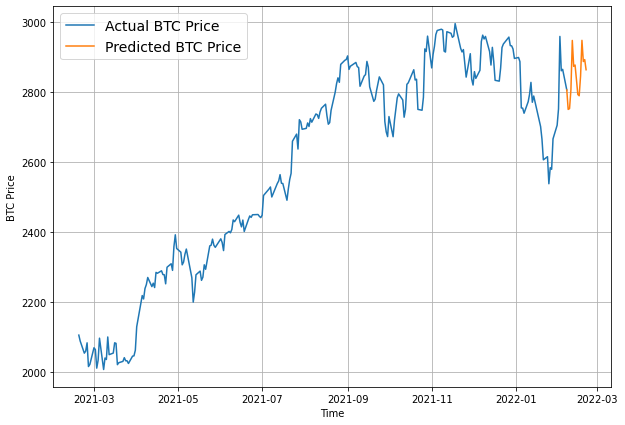

In [29]:
plt.figure(figsize=(10, 7))
plot_time_series(nbeats_data.index, y, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")